In [1]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'
save_path = '/content/drive/MyDrive'  # This is where MFCCs will be saved


In [4]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)

Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [5]:
# Initialize a dictionary to store file paths for each category
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Iterate over the dataset folders (Bonafide, Spoofed_TTS, Spoofed_Tacotron)
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        # Handle Bonafide folder with Part 1 and Part 2 subfolders
        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    file_path = os.path.join(part_path, file)
                    if file.endswith('.wav'):  # Check if it's a valid audio file
                        audio_files[category].append(file_path)

        # Handle Spoofed_TTS and Spoofed_Tacotron (assuming these don't have parts)
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                file_path = os.path.join(speaker_path, file)
                if file.endswith('.wav'):  # Check if it's a valid audio file
                    audio_files[category].append(file_path)

# Check the loaded audio files
print("Bonafide files:", audio_files['Bonafide'])
print("Spoofed_TTS files:", audio_files['Spoofed_TTS'])
print("Spoofed_Tacotron files:", audio_files['Spoofed_Tacotron'])

Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 371177.35it/s]

Bonafide files: ['/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/10.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/105.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/103.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/101.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/100.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/102.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/316.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/114.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/16.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/458.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/128.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/28.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/313.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/15.wav', '/content/drive/MyDri

In [6]:
import os
import numpy as np
import librosa
from tqdm import tqdm

def extract_mfcc(file_path, n_mfcc=40, max_length=500, sr=16000):
    audio, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]

    return mfcc

def extract_features_and_labels(dataset_path, n_mfcc=40, max_length=500):
    features = []
    labels = []

    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    if not os.path.isdir(part_path):
                        continue
                    for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                        file_path = os.path.join(part_path, file)
                        if file.endswith('.wav'):
                            try:
                                mfcc = extract_mfcc(file_path, n_mfcc, max_length)
                                features.append(mfcc)
                                labels.append(0)  # Bonafide
                            except Exception as e:
                                print(f"Error processing {file_path}: {e}")
            else:
                for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                    file_path = os.path.join(speaker_path, file)
                    if file.endswith('.wav'):
                        try:
                            mfcc = extract_mfcc(file_path, n_mfcc, max_length)
                            features.append(mfcc)
                            labels.append(1)  # Spoofed
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")

    return np.array(features), np.array(labels)


In [7]:
X, y = extract_features_and_labels(dataset_path)

# Save to /content/drive/MyDrive
np.save(os.path.join(save_path, 'mfcc_features.npy'), X)
np.save(os.path.join(save_path, 'labels.npy'), y)

print("Saved MFCC features and labels to Google Drive.")


Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Saved MFCC features and labels to Google Drive.


In [8]:
import numpy as np

# Load the features and labels
mfcc_features = np.load('/content/drive/MyDrive/mfcc_features.npy')
labels = np.load('/content/drive/MyDrive/labels.npy')

print("Total samples:", mfcc_features.shape[0])


Total samples: 6814


In [9]:
# Print shape and a small part of the MFCC arrays for two samples
for i in [0, 1]:
    print(f"\nSample {i + 1}")
    print("Label:", "Bonafide" if labels[i] == 0 else "Spoofed")
    print("MFCC shape:", mfcc_features[i].shape)
    print("MFCC (first 5 coefficients, first 10 frames):\n", mfcc_features[i][:5, :10])



Sample 1
Label: Bonafide
MFCC shape: (40, 500)
MFCC (first 5 coefficients, first 10 frames):
 [[-4.10134277e+02 -3.81305511e+02 -3.81009705e+02 -3.71409943e+02
  -3.34935608e+02 -3.20197235e+02 -3.12520050e+02 -3.05469513e+02
  -3.02936859e+02 -2.92689026e+02]
 [ 7.12999420e+01  6.79274368e+01  6.96647797e+01  6.95234833e+01
   4.38180237e+01  1.48611946e+01 -6.17164373e-03 -1.01007099e+01
  -1.43631363e+01  3.23866320e+00]
 [ 1.36033554e+01  2.01988335e+01  2.42645817e+01  2.60388336e+01
   4.40789642e+01  4.99742355e+01  5.26030350e+01  5.59831161e+01
   5.79693031e+01  6.57222290e+01]
 [ 1.89714432e+01  2.05210571e+01  2.15396156e+01  1.97127666e+01
   1.64651642e+01  2.29767265e+01  2.38312187e+01  2.61404610e+01
   2.55458717e+01  2.32929611e+01]
 [ 1.06223404e-01  1.54457247e+00  2.50926208e+00 -4.42854118e+00
  -1.88560715e+01 -2.05820236e+01 -2.26601219e+01 -2.22210579e+01
  -1.72849236e+01 -1.61046791e+01]]

Sample 2
Label: Bonafide
MFCC shape: (40, 500)
MFCC (first 5 coeffic

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import h5py
import os

# Step 1: Load MFCC features and labels
mfcc_path = '/content/drive/MyDrive/mfcc_features.npy'
labels_path = '/content/drive/MyDrive/labels.npy'
x = np.load(mfcc_path)
y = np.load(labels_path)

# Step 2: Flatten MFCCs (40 x 500 → 20000)
x = x.reshape(x.shape[0], -1)

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 5: Create DataLoaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Step 6: Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=20000, hidden_dim=512, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 7: Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=x_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Step 9: Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

# Step 10: Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Equal Error Rate (EER)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("\n=== Evaluation Metrics ===")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"EER        : {eer:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 11: Save model weights in .h5 format
save_path = '/content/drive/MyDrive/mlp_model_weights.h5'
# Save model state_dict properly
torch.save(model.state_dict(), "/content/drive/MyDrive/mlp_model.pth")
with h5py.File(save_path, 'w') as hf:
    for name, param in model.state_dict().items():
        hf.create_dataset(name, data=param.cpu().numpy())

print(f"\n✅ MLP model weights saved to: {save_path}")


Epoch 1/12, Loss: 3.2038
Epoch 2/12, Loss: 0.1582
Epoch 3/12, Loss: 0.0572
Epoch 4/12, Loss: 0.0581
Epoch 5/12, Loss: 0.0650
Epoch 6/12, Loss: 0.0268
Epoch 7/12, Loss: 0.0964
Epoch 8/12, Loss: 0.1205
Epoch 9/12, Loss: 0.0807
Epoch 10/12, Loss: 0.0177
Epoch 11/12, Loss: 0.0324
Epoch 12/12, Loss: 0.0076

=== Evaluation Metrics ===
Accuracy   : 0.9663
Precision  : 0.9953
F1 Score   : 0.9651
EER        : 0.0292
Confusion Matrix:
[[681   3]
 [ 43 636]]

✅ MLP model weights saved to: /content/drive/MyDrive/mlp_model_weights.h5


Accuracy: 0.9663
Precision: 0.9953
F1 Score: 0.9651


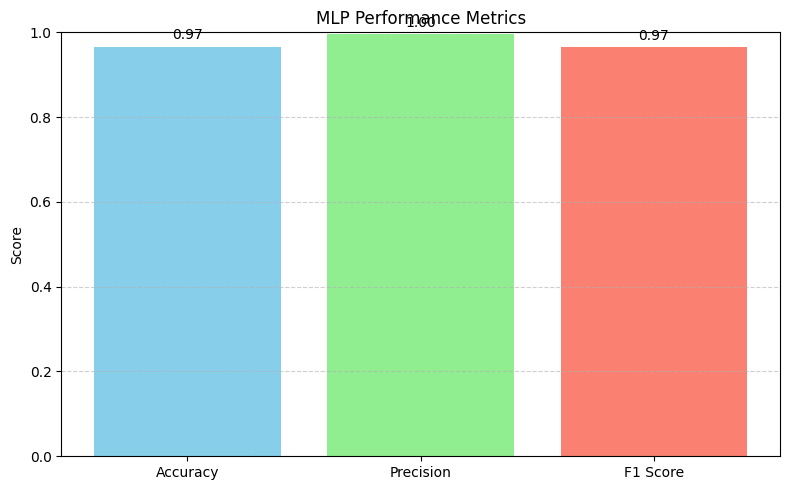

In [16]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: Define your MLP class again
# ----------------------------
class MLPForEmbeddings(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLPForEmbeddings, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ----------------------------
# Step 2: Load model and data
# ----------------------------
input_dim = 20000  # Since you flattened MFCCs of shape (40, 500)
model = MLPForEmbeddings(input_dim)
model.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model.pth'))
model.eval()

# Load your test data
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# ----------------------------
# Step 3: Run predictions and calculate metrics
# ----------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# ----------------------------
# Step 4: Visualize Bar Chart
# ----------------------------
metrics = [accuracy, precision, f1]
labels = ['Accuracy', 'Precision', 'F1 Score']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, metrics, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title("MLP Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add metric values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
